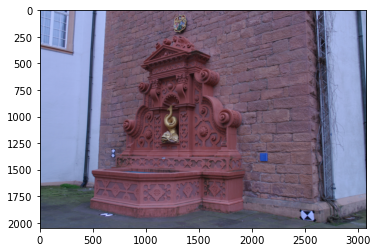

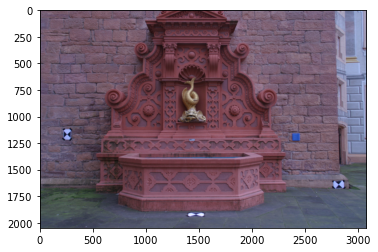

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pygcransac
from time import time

img1 = cv2.cvtColor(cv2.imread('../build/data/fountain/fountain1.jpg'), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread('../build/data/fountain/fountain2.jpg'), cv2.COLOR_BGR2RGB)
K1 = np.loadtxt('../build/data/fountain/fountain1.K')
K2 = np.loadtxt('../build/data/fountain/fountain2.K')
plt.imshow(img1)
plt.figure()
plt.imshow(img2)

In [14]:
#We will detect ORB features and match them with cross-check test
det = cv2.ORB_create(10000)    
kps1, descs1 = det.detectAndCompute(img1,None)
kps2, descs2 = det.detectAndCompute(img2,None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

tentatives = bf.match(descs1,descs2)

In [15]:
#Now, some visualization from OpenCV tutorial
#https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_feature_homography/py_feature_homography.html
#We will draw correspondences found and the geometric transformation between the images.
from copy import deepcopy
def decolorize(img):
    return  cv2.cvtColor(cv2.cvtColor(img,cv2.COLOR_RGB2GRAY), cv2.COLOR_GRAY2RGB)
def draw_matches(kps1, kps2, tentatives, img1, img2, mask):
    matchesMask = mask.ravel().tolist()
    # Blue is estimated, green is ground truth homography
    draw_params = dict(matchColor = (255,255,0), # draw matches in yellow color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
    img_out = cv2.drawMatches(decolorize(img1),kps1,img2,kps2,tentatives,None,**draw_params)
    plt.figure(figsize = (12,8))
    plt.imshow(img_out)
    return

In [16]:
img1.shape

(2048, 3072, 3)

293.0 inliers found
0.25730109214782715 sec cv2
512.0 inliers found
0.2114119529724121 sec gc-ransac


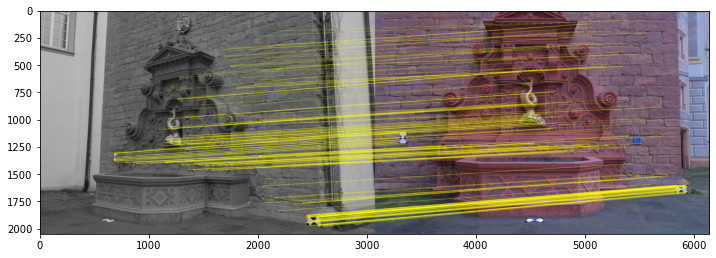

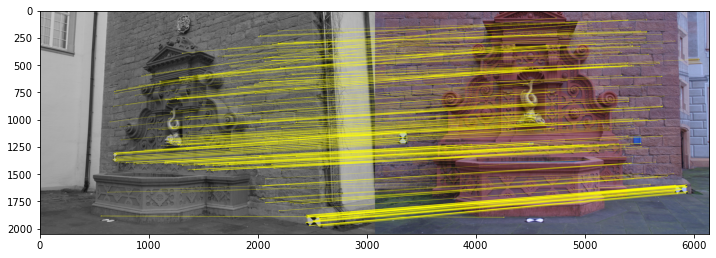

In [22]:

def verify_cv2_ess(kps1, kps2, tentatives, K1, K2, h1, w1, h2, w2):
    src_pts = np.float32([ kps1[m.queryIdx].pt for m in tentatives ]).reshape(-1,2)
    dst_pts = np.float32([ kps2[m.trainIdx].pt for m in tentatives ]).reshape(-1,2)
    
    # Normalize the threshold
    threshold = 0.75
    avgDiagonal = (K1[0][0] + K1[1][1] + K2[0][0] + K2[1][1]) / 4; 
    normalizedThreshold = threshold / avgDiagonal;
            
    # Normalize the point coordinates
    normalizedSourcePoints = cv2.undistortPoints(np.expand_dims(src_pts, axis=1), cameraMatrix=K1, distCoeffs=None)
    normalizedDestinationPoints = cv2.undistortPoints(np.expand_dims(dst_pts, axis=1), cameraMatrix=K2, distCoeffs=None)
    
    # Estimate the essential matrix from the normalized coordinates
    # using the normalized threshold.
    E, mask = cv2.findEssentialMat(normalizedSourcePoints, 
                                   normalizedDestinationPoints, 
                                   focal=1.0, 
                                   pp=(0., 0.),
                                   method=cv2.RANSAC, 
                                   prob=0.99,
                                   threshold=normalizedThreshold)

    print (deepcopy(mask).astype(np.float32).sum(), 'inliers found')
    return E, mask

def verify_pygcransac_ess(kps1, kps2, tentatives, K1, K2, h1, w1, h2, w2):
    src_pts = np.float32([ kps1[m.queryIdx].pt for m in tentatives ]).reshape(-1,2)
    dst_pts = np.float32([ kps2[m.trainIdx].pt for m in tentatives ]).reshape(-1,2)
    E, mask = pygcransac.findEssentialMatrix(
        np.ascontiguousarray(src_pts), 
        np.ascontiguousarray(dst_pts), 
        K1, 
        K2, 
        h1, w1, h2, w2, 
        0.75,
        0.99,
        0.0)
    print (deepcopy(mask).astype(np.float32).sum(), 'inliers found')
    return E, mask

t=time()
cv2_E, gc_cv2_mask = verify_cv2_ess(kps1, kps2, tentatives, K1, K2, img1.shape[0],img1.shape[1],
                                   img2.shape[0], img2.shape[1])
print (time()-t, 'sec cv2')

t=time()
gc_E, gc_E_mask = verify_pygcransac_ess(kps1, kps2, tentatives, K1, K2, img1.shape[0],img1.shape[1],
                                   img2.shape[0], img2.shape[1])
print (time()-t, 'sec gc-ransac')

draw_matches(kps1, kps2, tentatives, img1, img2, gc_cv2_mask)
draw_matches(kps1, kps2, tentatives, img1, img2, gc_E_mask)
